<a href="https://colab.research.google.com/github/felipemontano10/DeepLearning/blob/master/PS3_JFelipeMontanoCampos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ECE 685D - Fall 2020
## Problem Set 3 

> J. Felipe Montano-Campos

**Problem 3: Binary Classification with Generalized Linear Models**


In [5]:
import pandas as pd 
from sklearn.model_selection import train_test_split
import numpy as np
from numpy.linalg import inv
from sklearn import preprocessing

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving breast_cancer.csv to breast_cancer.csv


In [ ]:
#Data Preparation 
cancer_data = pd.read_csv("breast_cancer.csv") 

targets = cancer_data["diagnosis"]
targets = targets.replace({"B": 0, "M": 1})

features = ['radius_mean', 'texture_mean', 'smoothness_mean',
       'compactness_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'smoothness_se', 'compactness_se',
       'symmetry_se', 'fractal_dimension_se']

features_df = cancer_data[features]

X_train, X_test, y_train, y_test = train_test_split(features_df, targets, test_size=0.3, random_state=40)




**Discriminant Analysis**

In [ ]:
##Discriminant Analysis

def discriminant_binary(X_train, y_train, X_test, y_test):
    train = pd.concat([X_train, y_train], axis=1, sort=False)
    train_1 = train.loc[train["diagnosis"]==1]
    train_1 = train_1.drop(columns = ["diagnosis"])
    train_0 = train.loc[train["diagnosis"]==0]    
    train_0 = train_0.drop(columns = ["diagnosis"])
    sigma_1 = np.cov(train_1.T)
    sigma_0 = np.cov(train_0.T)
    sigma =  (train_1.shape[0]/train.shape[0])*sigma_1 +(train_0.shape[0]/train.shape[0])*sigma_0
    sigma_inv = inv(sigma)
    mu_1 = train.loc[train["diagnosis"]==1].mean() 
    mu_2 = train.loc[train["diagnosis"]==0].mean()
    mu_1 = np.array(mu_1.drop(index = "diagnosis"))
    mu_2 = np.array(mu_2.drop(index = "diagnosis"))
    p_c1 = np.mean(np.array(train["diagnosis"]))
    p_c2 = 1-p_c1
    w = np.matmul(sigma_inv,(mu_1-mu_2))
    w_0 = -0.5*np.matmul(np.matmul(mu_1.T,sigma_inv),mu_1)+ 0.5*np.matmul(np.matmul(mu_2.T,sigma_inv),mu_2)+np.log(p_c1/p_c2)
    train_pred = w_0 + np.matmul(np.array(X_train),w)
    train_pred[train_pred > 0] =1
    train_pred[train_pred < 0] = 0
    correct_train = (train_pred == y_train)
    accuracy_train = correct_train.sum() / correct_train.size
    test_pred = w_0 + np.matmul(np.array(X_test),w)
    test_pred[test_pred > 0] =1
    test_pred[test_pred < 0] = 0
    correct_test = (test_pred == y_test)    
    accuracy_test = correct_test.sum() / correct_test.size
    
    return (accuracy_test, accuracy_train)

In [ ]:
test_acc, train_acc = discriminant_binary(X_train, y_train, X_test, y_test)
print("Training Accuracy:"+str(train_acc)) 
print("Test Accuracy:"+str(test_acc)) 

Training Accuracy:0.9246231155778895
Test Accuracy:0.9532163742690059


**Logistic Regression**

In [ ]:
#Import Packages
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

#Pre Process Data
X_train = preprocessing.scale(X_train)
X_test = preprocessing.scale(X_test)

In [ ]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim,bias=False)

    def forward(self, x):
        out = self.linear(x)
        return out


n_epochs = 50
n_samples = X_train.shape[0]
n_features = X_train.shape[1]
n_classes = y_train.value_counts().shape[0]
learning_rate = 0.1

In [ ]:
#Define the Logistic Regression Function to train the model

def LR(X_train, y_train, X_test, y_test, n_epochs, n_features,n_classes,learning_rate):
    X, y = torch.from_numpy(np.array(X_train)).float(), torch.from_numpy(np.array(y_train)).long()
    Xtest, ytest = torch.from_numpy(np.array(X_test)).float(), torch.from_numpy(np.array(y_test)).long()    
    model = LogisticRegressionModel(n_features, n_classes)
    optimizer = torch.optim.SGD(model.parameters(), lr= learning_rate) # Experiment to see the senstivity of learning rate with SGD
    criterion = nn.CrossEntropyLoss()
    # Train
    model.train('True')
    loss_train = []
    loss_test = []
    train_list = []
    test_list = []
    for epoch in range(n_epochs):
        y_hat = model(X)
        loss = criterion(y_hat.squeeze(), y)
        optimizer.zero_grad()
        loss.backward() # Backward Pass
        optimizer.step()
        loss_train.append(loss.item())
        #Training Accuracy
        _, predicted = torch.max(y_hat.data,1)
        correct = (predicted == y) 
        accuracy = int(correct.sum()) / correct.shape[0]
        train_list.append(accuracy)
        #Test Accuracy
        y_hat_test = model(Xtest)     
        losstest = criterion(y_hat_test.squeeze(), ytest)
        loss_test.append(losstest.item())
        _, predicted_test = torch.max(y_hat_test.data,1)
        correct_test = (predicted_test == ytest)    
        accuracy_test = int(correct_test.sum()) / correct_test.shape[0]
        print("Epoch number: "+str(epoch)+" | Training Accuracy: "+str(accuracy)+" | Test Accuracy: "+str(accuracy_test))
        test_list.append(accuracy_test)
    return (loss_train, loss_test ,train_list,test_list)


In [ ]:
loss_train, loss_test, train_list, test_list = LR(X_train, y_train, X_test, y_test, n_epochs, n_features,n_classes,learning_rate)


Epoch number: 0 | Training Accuracy: 0.7160804020100503 | Test Accuracy: 0.7894736842105263
Epoch number: 1 | Training Accuracy: 0.7688442211055276 | Test Accuracy: 0.8011695906432749
Epoch number: 2 | Training Accuracy: 0.8065326633165829 | Test Accuracy: 0.8128654970760234
Epoch number: 3 | Training Accuracy: 0.8266331658291457 | Test Accuracy: 0.8245614035087719
Epoch number: 4 | Training Accuracy: 0.8442211055276382 | Test Accuracy: 0.8362573099415205
Epoch number: 5 | Training Accuracy: 0.8618090452261307 | Test Accuracy: 0.8421052631578947
Epoch number: 6 | Training Accuracy: 0.8743718592964824 | Test Accuracy: 0.8596491228070176
Epoch number: 7 | Training Accuracy: 0.8869346733668342 | Test Accuracy: 0.8654970760233918
Epoch number: 8 | Training Accuracy: 0.8969849246231156 | Test Accuracy: 0.8888888888888888
Epoch number: 9 | Training Accuracy: 0.9045226130653267 | Test Accuracy: 0.8888888888888888
Epoch number: 10 | Training Accuracy: 0.9045226130653267 | Test Accuracy: 0.8888

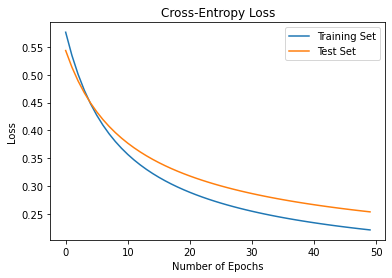

In [ ]:
##Plot losses

plt.plot(list(range(n_epochs)),loss_train, label = "Training Set" )
plt.plot(list(range(n_epochs)),loss_test, label = "Test Set" )
plt.title('Cross-Entropy Loss')
plt.ylabel('Loss')
plt.xlabel('Number of Epochs')
plt.legend(loc='upper right')
plt.show()

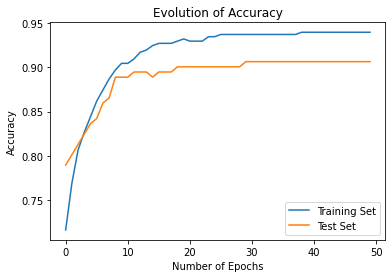

In [ ]:

#Plot Accuracy
plt.plot(list(range(n_epochs)),train_list, label = "Training Set" )
plt.plot(list(range(n_epochs)),test_list, label = "Test Set" )
plt.title('Evolution of Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of Epochs')
plt.legend(loc='lower right')
plt.show()

**Problem 4: Binary Classification with Neural Networks**

**2.a**

In [ ]:
#Data Preparation 
cancer_data = pd.read_csv("breast_cancer.csv") 

targets = cancer_data["diagnosis"]
targets = targets.replace({"B": 0, "M": 1})

features = ['radius_mean', 'texture_mean', 'smoothness_mean',
       'compactness_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'smoothness_se', 'compactness_se',
       'symmetry_se', 'fractal_dimension_se']

features_df = cancer_data[features]

X_train, X_test, y_train, y_test = train_test_split(features_df, targets, test_size=0.3, random_state=40)
X_train = preprocessing.scale(X_train)
X_test = preprocessing.scale(X_test)

In [7]:
#Let's define a class of a Multiilayer Perceptron Model. 
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt




class MLP(nn.Module):
    def __init__(self, inputs, outputs, hidden_layers, neurons_per_layer, bias):
        super(MLP, self).__init__()
        # initialize empty list of fully connected layers
        hidden = nn.ModuleList()
        
        # append input layer
        self.input = nn.Linear(in_features = inputs, out_features = neurons_per_layer, bias = bias)
        
        # add hidden_layers
        self.hidden_layers = hidden_layers
        for i in range(hidden_layers):
            hidden.append(nn.Linear(in_features = neurons_per_layer, out_features = neurons_per_layer, bias = bias))
        
        # add output layer
        self.output = nn.Linear(in_features = neurons_per_layer, out_features = outputs, bias = bias)
        
        # create model
        self.hidden = hidden
        
    def forward(self, x):
        x = torch.relu(self.input(x))
        for i in range(self.hidden_layers):
            x = torch.relu(self.hidden[i](x))
        
        x = self.output(x)
        return x


In [ ]:
#Let's define our parameters         
inputs =  X_train.shape[1] #Refer to the features
outputs = y_train.value_counts().shape[0] #Refer to the labels 
hidden_layers = 2
neurons = 16
n_epochs = 400
learning_rate  = 0.01
#Conver to torch our training and test set 
Xtrain, ytrain = torch.from_numpy(np.array(X_train)).float(), torch.from_numpy(np.array(y_train)).long()
Xtest, ytest = torch.from_numpy(np.array(X_test)).float(), torch.from_numpy(np.array(y_test)).long()


In [ ]:
#Define our model 
model =  MLP(inputs = inputs, outputs = outputs, hidden_layers = hidden_layers, neurons_per_layer = neurons, bias = True)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
#Info that we need 
train_acc = []
test_acc = []
train_loss = []
test_loss = []
#Lets train the model:
for epochs in range(n_epochs):
    model.train()
    optimizer.zero_grad() #Forward pass
    y_hat = model(Xtrain) #Train Prediction
    loss = criterion(y_hat,ytrain)
    _, predicted = torch.max(y_hat.data,1)
    correct = (predicted == ytrain)    
    accuracy = int(correct.sum()) / correct.shape[0]
    train_acc.append(accuracy)
    train_loss.append(loss.item())
    model.eval()
    y_hat_test = model(Xtest)
    loss_test = criterion(y_hat_test, ytest)
    _, predicted_test = torch.max(y_hat_test.data,1)
    correct_test = (predicted_test == ytest)    
    accuracy_test = int(correct_test.sum()) / correct_test.shape[0]    
    test_acc.append(accuracy_test)
    test_loss.append(loss_test.item())    
    loss.backward()
    optimizer.step()


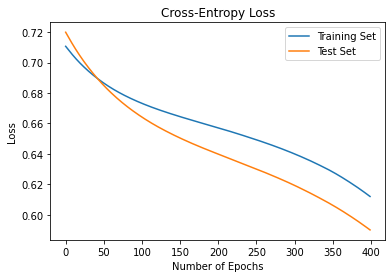

In [ ]:
##Plot losses

plt.plot(list(range(n_epochs)),train_loss, label = "Training Set" )
plt.plot(list(range(n_epochs)),test_loss, label = "Test Set" )
plt.title('Cross-Entropy Loss')
plt.ylabel('Loss')
plt.xlabel('Number of Epochs')
plt.legend(loc='upper right')
plt.show()

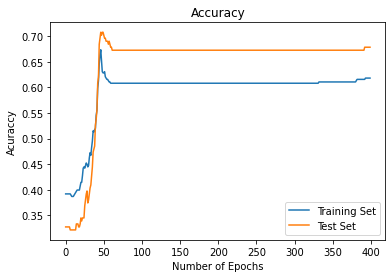

In [ ]:
##Plot accuracy

plt.plot(list(range(n_epochs)),train_acc, label = "Training Set" )
plt.plot(list(range(n_epochs)),test_acc, label = "Test Set" )
plt.title('Accuracy')
plt.ylabel('Acuraccy')
plt.xlabel('Number of Epochs')
plt.legend(loc='lower right')
plt.show()


**2b.**

In [ ]:
#Definte the number of Hidden Layers and Neurons
N_list = [1,2,3,4,5,6,7,8]
M_list = [ 2 , 4 , 8 , 16, 32, 64, 128]
inputs =  X_train.shape[1] #Refer to the features
outputs = y_train.value_counts().shape[0] #Refer to the labels 
n_epochs = 400
learning_rate  = 0.01
#Matrix where to store the results 
gradients = np.empty([len(N_list),len(M_list)])
accuracy = np.empty([len(N_list),len(M_list)])       
#Lets Define our loop 

for N in range(len(N_list)):
    for M in range(len(M_list)):
        model =  MLP(inputs = inputs, outputs = outputs, hidden_layers = N_list[N], neurons_per_layer = M_list[M], bias = True)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
        #Info that we need 
        test_acc = []
        #Lets train the model:
        for epochs in range(n_epochs):
            model.train()
            optimizer.zero_grad() #Forward pass
            y_hat = model(Xtrain) #Train Prediction
            loss = criterion(y_hat,ytrain)
#            _, predicted = torch.max(y_hat.data,1)
#            correct = (predicted == ytrain)    
#            accuracy = int(correct.sum()) / correct.shape[0]
            model.eval()
            y_hat_test = model(Xtest)
            loss_test = criterion(y_hat_test, ytest)
            _, predicted_test = torch.max(y_hat_test.data,1)
            correct_test = (predicted_test == ytest)    
            accuracy_test = int(correct_test.sum()) / correct_test.shape[0]    
            test_acc.append(accuracy_test)
            loss.backward()
            optimizer.step()
            if epochs==n_epochs-1:
                grad = np.linalg.norm(np.array(model.input.weight.grad))

        accuracy[N,M] = test_acc[-1]
        gradients[N,M] = grad


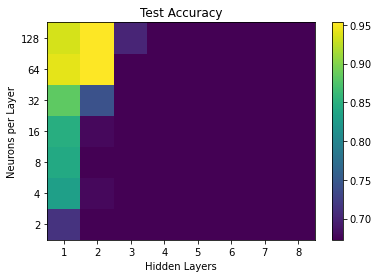

In [ ]:
# Heat map for the Accuracy in the Test Test
plt.pcolormesh(np.transpose(accuracy))
plt.xticks(np.arange(0.5, 8.5, 1), N_list)
plt.yticks(np.arange(0.5, 7.5, 1), M_list)
plt.colorbar()
plt.title('Test Accuracy')
plt.ylabel('Neurons per Layer')
plt.xlabel('Hidden Layers')
plt.show()

As we can see in the heat map, the more neurons per layer we have, conditionally on having not many hidden layers, the better is the test accuracy. On the other hand, we can see that as the hidden layers increase, for any number of neurons per layer, the test accuracy decreases since we are over-fitting the training data. In other words, we need to feed the model with more data so the test accuracy gets increased. 

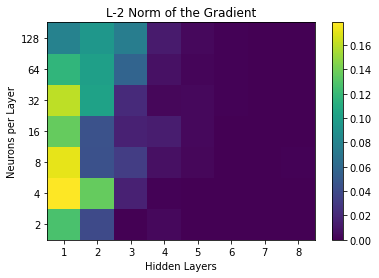

In [ ]:
# Heat map for the Gradient
plt.pcolormesh(np.transpose(gradients))
plt.xticks(np.arange(0.5, 8.5, 1), N_list)
plt.yticks(np.arange(0.5, 7.5, 1), M_list)
plt.colorbar()
plt.title('L-2 Norm of the Gradient')
plt.ylabel('Neurons per Layer')
plt.xlabel('Hidden Layers')
plt.show()

As we can see in the heat map, the L-2 Norm of the gradient of the weights that connect the input layer with the first hidden layer is bigger when we have less number of hidden layers, for all the specifications of Neurons per layer. This is the case because the less hidden layeres the model has, the less complex is. So, at each iteration the weights are updated in greater quantities since the model does not have many layers to learn. On the other hand, when we have complex models, the weights of all the hidden layers are being updated so the weights of the input layer will be less modified because the model is learning in several hidden layers.

**3.**

In [ ]:
#Let's define the parameters
inputs =  X_train.shape[1] #Refer to the features
outputs = y_train.value_counts().shape[0] #Refer to the labels 
hidden_layers = 2
neurons = 16
n_epochs = 400
learning_rate  = 0.01
#Define our model 
model =  MLP(inputs = inputs, outputs = outputs, hidden_layers = hidden_layers, neurons_per_layer = neurons, bias = True)
criterion = nn.CrossEntropyLoss()
#Info that we need 
train_acc = []
test_acc = []
train_loss = []
test_loss = []
#Lets train the model:
for epochs in range(n_epochs):
    model.train()
    optimizer.zero_grad() #Forward pass
    y_hat = model(Xtrain) #Train Prediction
    loss = criterion(y_hat,ytrain)
    _, predicted = torch.max(y_hat.data,1)
    correct = (predicted == ytrain)    
    accuracy = int(correct.sum()) / correct.shape[0]
    train_acc.append(accuracy)
    train_loss.append(loss.item())
    #Initialize weights and bias
    w_1 = torch.zeros(16,12)
    w_2 = torch.zeros(16,16)
    w_3 = torch.zeros(16,16)
    w_4 = torch.zeros(2,16)
    b_1 = torch.zeros(16)
    b_2 = torch.zeros(16)
    b_3 = torch.zeros(16)
    b_4 = torch.zeros(2)
    #Backpropagation
    for i in range(Xtrain.shape[0]):
        #Forward pass
        z_2 = torch.matmul(model.input.weight, Xtrain[i]) + model.input.bias
        a_2 = torch.relu(z_2)
        z_3 = torch.matmul(model.hidden[0].weight, a_2) + model.hidden[0].bias
        a_3 = torch.relu(z_3)
        z_4 = torch.matmul(model.hidden[1].weight, a_3) + model.hidden[1].bias
        a_4 = torch.relu(z_4)
        z_5 = torch.matmul(model.output.weight, a_4) + model.output.bias      
        #Compute output error grdient
        delta_4 = - torch.tensor([(1 - ytrain[i]), ytrain[i]]) + torch.exp(z_5) / torch.sum(torch.exp(z_5))
        #For the previous layers
        delta_3 = torch.mul(torch.matmul(torch.transpose(model.output.weight, 0, 1), delta_4), (z_4 > 0))
        delta_2 = torch.mul(torch.matmul(torch.transpose(model.hidden[1].weight, 0, 1), delta_3), (z_3 > 0))
        delta_1 = torch.mul(torch.matmul(torch.transpose(model.hidden[0].weight, 0, 1), delta_2), (z_2 > 0))
        #Gradients
        w_1 += torch.ger(delta_1,Xtrain[i])/Xtrain.shape[0]   
        w_2 += torch.ger(delta_2, a_2) / Xtrain.shape[0]
        w_3 += torch.ger(delta_3, a_3) / Xtrain.shape[0]
        w_4 += torch.ger(delta_4, a_4) / Xtrain.shape[0]
        b_1 += delta_1/Xtrain.shape[0]   
        b_2 += delta_2/Xtrain.shape[0]
        b_3 += delta_3/Xtrain.shape[0]
        b_4 += delta_4/Xtrain.shape[0]
    with torch.no_grad():
            model.input.weight -= learning_rate*w_1
            model.input.bias -= learning_rate*b_1
            model.hidden[0].weight -= learning_rate*w_2
            model.hidden[0].bias -= learning_rate*b_2
            model.hidden[1].weight -= learning_rate*w_3
            model.hidden[1].bias -= learning_rate*b_3
            model.output.weight -= learning_rate*w_4
            model.output.bias -= learning_rate*b_4        
    model.eval()
    y_hat_test = model(Xtest)
    loss_test = criterion(y_hat_test, ytest)
    _, predicted_test = torch.max(y_hat_test.data,1)
    correct_test = (predicted_test == ytest)    
    accuracy_test = int(correct_test.sum()) / correct_test.shape[0]    
    test_acc.append(accuracy_test)
    test_loss.append(loss_test.item())   

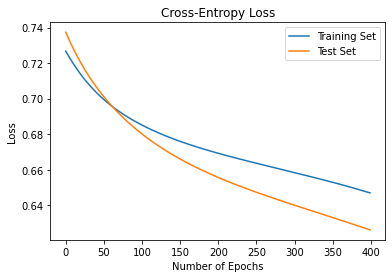

In [ ]:
##Plot losses

plt.plot(list(range(n_epochs)),train_loss, label = "Training Set" )
plt.plot(list(range(n_epochs)),test_loss, label = "Test Set" )
plt.title('Cross-Entropy Loss')
plt.ylabel('Loss')
plt.xlabel('Number of Epochs')
plt.legend(loc='upper right')
plt.show()

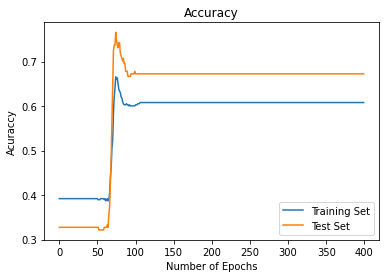

In [ ]:
##Plot accuracy

plt.plot(list(range(n_epochs)),train_acc, label = "Training Set")
plt.plot(list(range(n_epochs)),test_acc, label = "Test Set" )
plt.title('Accuracy')
plt.ylabel('Acuraccy')
plt.xlabel('Number of Epochs')
plt.legend(loc='lower right')
plt.show()



**Problem 5: First-order Optimization Methods**

In [1]:
import scipy
import scipy.io



In [2]:
from google.colab import files
uploaded = files.upload()

Saving mnist-original.mat to mnist-original.mat


In [8]:
#import Data
mnist_data = scipy.io.loadmat('mnist-original.mat')
X = mnist_data['data'].T
y = mnist_data['label'].T
#Pre process
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)
#Train and test set
train_dataset, test_dataset, train_labels, test_labels = train_test_split(X, y, test_size=1/7, random_state=671)
train_labels = pd.get_dummies(pd.DataFrame(train_labels)[0], prefix='numb')
test_labels = pd.get_dummies(pd.DataFrame(test_labels)[0], prefix='numb')
print (train_dataset.shape, train_labels.shape)
print (test_dataset.shape, test_labels.shape)
#Get everything in np.array
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)
#Use Pytorch
X, y = torch.from_numpy(np.array(train_dataset)).float(), torch.from_numpy(np.array(train_labels)).long()
Xtest, ytest = torch.from_numpy(np.array(test_dataset)).float(), torch.from_numpy(np.array(test_labels)).long()


(60000, 784) (60000, 10)
(10000, 784) (10000, 10)


In [9]:
#Define logistic regression
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim,bias=True)

    def forward(self, x):
        out = self.linear(x)
        return out

**Momentum Method**

In [ ]:
#Initialize Model Parameters

lambdas = [0.01,0.1,1]
learning_rate = 0.001
beta = 0.9
n_epochs = 200      
batch_sizes = [500,60000]    
    
#Estimation 
for batch_size in batch_sizes:
    print("BATCH SIZE:"+str(batch_size))
    for lambda_param in lambdas:
        model = LogisticRegressionModel(X.shape[1], y.shape[1])
        criterion = nn.CrossEntropyLoss()
        m_w = torch.zeros((X.shape[1],y.shape[1] ))
        m_w = m_w.T
        m_b = torch.zeros(y.shape[1])
        print("LAMBDA:"+str(lambda_param))
        for epoch in list(range(n_epochs))[1:]:
             # X is a torch Variable
            permutation = torch.randperm(X.size()[0])
            for i in range(0,X.size()[0], batch_size):
                indices = permutation[i:i+batch_size]
                batch_x, batch_y = X[indices], y[indices]
                y_hat = model(batch_x)
                b = list(model.parameters())[1]
                w = list(model.parameters())[0]
                l2_regularization = torch.norm(b) + torch.norm(w)
                loss = criterion(y_hat.squeeze(), torch.max(batch_y, 1)[1]) + lambda_param*l2_regularization
                if w.grad is not None:
                    w.grad.zero_()
                if b.grad is not None:
                    b.grad.zero_()
                loss.backward()
                with torch.no_grad():  # 3
                    m_w = beta*m_w + w.grad
                    m_b = beta*m_b +b.grad
                    w -= learning_rate * m_w
                    b -= learning_rate * m_b
                #Test Accuracy
            y_hat_test = model(Xtest)     
            _, predicted_test = torch.max(y_hat_test.data,1)
            correct_test = (predicted_test == torch.max(ytest, 1)[1])    
            accuracy_test = int(correct_test.sum()) / correct_test.shape[0]
            if (epoch+1)%(5*10)==0:    
                print("Epoch number:"+str(epoch+1)+" | Test Accuracy "+str(accuracy_test))



BATCH SIZE:500
LAMBDA:0.01
Epoch number:50 | Test Accuracy 0.8896
Epoch number:100 | Test Accuracy 0.8978
Epoch number:150 | Test Accuracy 0.9017
Epoch number:200 | Test Accuracy 0.9046
LAMBDA:0.1
Epoch number:50 | Test Accuracy 0.879
Epoch number:100 | Test Accuracy 0.8814
Epoch number:150 | Test Accuracy 0.8818
Epoch number:200 | Test Accuracy 0.8816
LAMBDA:1
Epoch number:50 | Test Accuracy 0.7401
Epoch number:100 | Test Accuracy 0.6525
Epoch number:150 | Test Accuracy 0.6669
Epoch number:200 | Test Accuracy 0.7163
BATCH SIZE:60000
LAMBDA:0.01
Epoch number:50 | Test Accuracy 0.5927
Epoch number:100 | Test Accuracy 0.7334
Epoch number:150 | Test Accuracy 0.7708
Epoch number:200 | Test Accuracy 0.7922
LAMBDA:0.1
Epoch number:50 | Test Accuracy 0.6487
Epoch number:100 | Test Accuracy 0.7501
Epoch number:150 | Test Accuracy 0.7771
Epoch number:200 | Test Accuracy 0.7925
LAMBDA:1
Epoch number:50 | Test Accuracy 0.6244
Epoch number:100 | Test Accuracy 0.7464
Epoch number:150 | Test Accurac

In [ ]:
#Initialize Model Parameters

lambdas = [0.01,0.1,1]
learning_rate = 0.001
beta = 0.9
n_epochs = 2      
batch_sizes = [1]    
    
#Estimation 
for batch_size in batch_sizes:
    print("BATCH SIZE:"+str(batch_size))
    for lambda_param in lambdas:
        model = LogisticRegressionModel(X.shape[1], y.shape[1])
        criterion = nn.CrossEntropyLoss()
        m_w = torch.zeros((X.shape[1],y.shape[1] ))
        m_w = m_w.T
        m_b = torch.zeros(y.shape[1])
        print("LAMBDA:"+str(lambda_param))
        for epoch in list(range(n_epochs))[1:]:
             # X is a torch Variable
            permutation = torch.randperm(X.size()[0])
            for i in range(0,X.size()[0], batch_size):
                indices = permutation[i:i+batch_size]
                batch_x, batch_y = X[indices], y[indices]
                y_hat = model(batch_x)
                b = list(model.parameters())[1]
                w = list(model.parameters())[0]
                l2_regularization = torch.norm(b) + torch.norm(w)
                loss = criterion(y_hat, torch.max(batch_y, 1)[1]) + lambda_param*l2_regularization
                if w.grad is not None:
                    w.grad.zero_()
                if b.grad is not None:
                    b.grad.zero_()
                loss.backward()
                with torch.no_grad():  # 3
                    m_w = beta*m_w + w.grad
                    m_b = beta*m_b +b.grad
                    w -= learning_rate * m_w
                    b -= learning_rate * m_b
                #Test Accuracy
            y_hat_test = model(Xtest)     
            _, predicted_test = torch.max(y_hat_test.data,1)
            correct_test = (predicted_test == torch.max(ytest, 1)[1])    
            accuracy_test = int(correct_test.sum()) / correct_test.shape[0]
            if (epoch+1)%(1)==0:    
                print("Epoch number:"+str(epoch+1)+" | Test Accuracy "+str(accuracy_test))


BATCH SIZE:1
LAMBDA:0.01
Epoch number:2 | Test Accuracy 0.9019
LAMBDA:0.1
Epoch number:2 | Test Accuracy 0.8613
LAMBDA:1
Epoch number:2 | Test Accuracy 0.4374


**NAG Method**

In [11]:
lambdas = [0.01,0.1,1]
learning_rate = 0.001
beta = 0.95
n_epochs = 200    
batch_sizes = [500,60000]    
    
#Estimation 
for batch_size in batch_sizes:
    print("BATCH SIZE:"+str(batch_size))
    for lambda_param in lambdas:
        model = LogisticRegressionModel(X.shape[1], y.shape[1])
        criterion = nn.CrossEntropyLoss()
        m_w = torch.zeros((X.shape[1],y.shape[1] ))
        m_w = m_w.T
        m_b = torch.zeros(y.shape[1]) 
        lambdas_sequence = [0]
        print("LAMBDA:"+str(lambda_param))
        for epoch in range(n_epochs):
             # X is a torch Variable
            permutation = torch.randperm(X.size()[0])
            lambdas_sequence.append((1+(1+4*lambdas_sequence[epoch]**2)**(0.5))/2)
            gamma = (1-lambdas_sequence[epoch])/lambdas_sequence[epoch+1]
            for i in range(0,X.size()[0], batch_size):
                indices = permutation[i:i+batch_size]
                batch_x, batch_y = X[indices], y[indices]
                y_hat = model(batch_x)
                w = list(model.parameters())[0]
                b = list(model.parameters())[1]
                l2_regularization = torch.norm(b) + torch.norm(w)
                loss = criterion(y_hat.squeeze(), torch.max(batch_y, 1)[1]) + lambda_param*l2_regularization
                if w.grad is not None:
                    w.grad.zero_()
                if b.grad is not None:
                    b.grad.zero_()    
                loss.backward()
                
                with torch.no_grad():
                    m_w_old = m_w
                    m_b_old = m_b
                    m_w = w  - (1/beta)*w.grad
                    m_b = b - (1/beta)*b.grad
                    w = (1-gamma)*m_w+gamma*m_w_old
                    b = (1-gamma)*m_b+gamma*m_b_old
                model.linear.weight.data = w.clone()
                model.linear.bias.data = b.clone()
            #Test Accuracy
            y_hat_test = model(Xtest)     
            _, predicted_test = torch.max(y_hat_test.data,1)
            correct_test = (predicted_test == torch.max(ytest, 1)[1])    
            accuracy_test = int(correct_test.sum()) / correct_test.shape[0]
            if (epoch+1)%(10*5)==0:    
                print("Epoch number:"+str(epoch+1)+" | Test Accuracy "+str(accuracy_test))


BATCH SIZE:500
LAMBDA:0.01
Epoch number:50 | Test Accuracy 0.8935
Epoch number:100 | Test Accuracy 0.8764
Epoch number:150 | Test Accuracy 0.8575
Epoch number:200 | Test Accuracy 0.8787
LAMBDA:0.1
Epoch number:50 | Test Accuracy 0.7738
Epoch number:100 | Test Accuracy 0.6157
Epoch number:150 | Test Accuracy 0.6498
Epoch number:200 | Test Accuracy 0.7572
LAMBDA:1
Epoch number:50 | Test Accuracy 0.3086
Epoch number:100 | Test Accuracy 0.5147
Epoch number:150 | Test Accuracy 0.4211
Epoch number:200 | Test Accuracy 0.4493
BATCH SIZE:60000
LAMBDA:0.01
Epoch number:50 | Test Accuracy 0.9
Epoch number:100 | Test Accuracy 0.8993
Epoch number:150 | Test Accuracy 0.9003
Epoch number:200 | Test Accuracy 0.9041
LAMBDA:0.1
Epoch number:50 | Test Accuracy 0.8721
Epoch number:100 | Test Accuracy 0.6815
Epoch number:150 | Test Accuracy 0.5388
Epoch number:200 | Test Accuracy 0.5801
LAMBDA:1
Epoch number:50 | Test Accuracy 0.2401
Epoch number:100 | Test Accuracy 0.2899
Epoch number:150 | Test Accuracy 

In [12]:
lambdas = [0.01,0.1,1]
learning_rate = 0.001
beta = 0.95
n_epochs = 2    
batch_sizes = [1]    
    
#Estimation 
for batch_size in batch_sizes:
    print("BATCH SIZE:"+str(batch_size))
    for lambda_param in lambdas:
        model = LogisticRegressionModel(X.shape[1], y.shape[1])
        criterion = nn.CrossEntropyLoss()
        m_w = torch.zeros((X.shape[1],y.shape[1] ))
        m_w = m_w.T
        m_b = torch.zeros(y.shape[1]) 
        lambdas_sequence = [0]
        print("LAMBDA:"+str(lambda_param))
        for epoch in range(n_epochs):
             # X is a torch Variable
            permutation = torch.randperm(X.size()[0])
            lambdas_sequence.append((1+(1+4*lambdas_sequence[epoch]**2)**(0.5))/2)
            gamma = (1-lambdas_sequence[epoch])/lambdas_sequence[epoch+1]
            for i in range(0,X.size()[0], batch_size):
                indices = permutation[i:i+batch_size]
                batch_x, batch_y = X[indices], y[indices]
                y_hat = model(batch_x)
                w = list(model.parameters())[0]
                b = list(model.parameters())[1]
                l2_regularization = torch.norm(b) + torch.norm(w)
                loss = criterion(y_hat, torch.max(batch_y, 1)[1]) + lambda_param*l2_regularization
                if w.grad is not None:
                    w.grad.zero_()
                if b.grad is not None:
                    b.grad.zero_()    
                loss.backward()
                
                with torch.no_grad():
                    m_w_old = m_w
                    m_b_old = m_b
                    m_w = w  - (1/beta)*w.grad
                    m_b = b - (1/beta)*b.grad
                    w = (1-gamma)*m_w+gamma*m_w_old
                    b = (1-gamma)*m_b+gamma*m_b_old
                model.linear.weight.data = w.clone()
                model.linear.bias.data = b.clone()
            #Test Accuracy
            y_hat_test = model(Xtest)     
            _, predicted_test = torch.max(y_hat_test.data,1)
            correct_test = (predicted_test == torch.max(ytest, 1)[1])    
            accuracy_test = int(correct_test.sum()) / correct_test.shape[0]
            if (epoch+1)%(1)==0:    
                print("Epoch number:"+str(epoch+1)+" | Test Accuracy "+str(accuracy_test))



BATCH SIZE:1
LAMBDA:0.01
Epoch number:1 | Test Accuracy 0.8398
Epoch number:2 | Test Accuracy 0.822
LAMBDA:0.1
Epoch number:1 | Test Accuracy 0.738
Epoch number:2 | Test Accuracy 0.678
LAMBDA:1
Epoch number:1 | Test Accuracy 0.383
Epoch number:2 | Test Accuracy 0.2667


**RMSprop Method**

In [ ]:
#Initialize Model Parameters
lambdas = [0.01,0.1,1]
learning_rate = 0.001
beta = 0.9
gamma = 1
epsilon = 10**(-8)
n_epochs = 200     
batch_sizes = [500,60000]    
    
#Estimation 
for batch_size in batch_sizes:
    print("BATCH SIZE:"+str(batch_size))
    for lambda_param in lambdas:
        model = LogisticRegressionModel(X.shape[1], y.shape[1])
        criterion = nn.CrossEntropyLoss()
        v_w = torch.zeros((X.shape[1],y.shape[1] ))
        v_w = v_w.T
        v_b = torch.zeros(y.shape[1])    
        print("LAMBDA:"+str(lambda_param))
        for epoch in list(range(n_epochs))[1:]:
             # X is a torch Variable
            permutation = torch.randperm(X.size()[0])
            for i in range(0,X.size()[0], batch_size):
                indices = permutation[i:i+batch_size]
                batch_x, batch_y = X[indices], y[indices]
                y_hat = model(batch_x)
                b = list(model.parameters())[1]
                w = list(model.parameters())[0]
                l2_regularization = torch.norm(b) + torch.norm(w)
                loss = criterion(y_hat.squeeze(), torch.max(batch_y, 1)[1]) + lambda_param*l2_regularization
                if w.grad is not None:
                    w.grad.zero_()
                if b.grad is not None:
                    b.grad.zero_()
                loss.backward()
                with torch.no_grad():  # 3
                    v_w = (1-beta)*v_w + beta*(w.grad*w.grad)
                    v_b = (1-beta)*v_b + beta*(b.grad*b.grad)
                    b_w = torch.div(gamma, epsilon + torch.sqrt(v_w)) 
                    b_b = torch.div(gamma, epsilon + torch.sqrt(v_b))
                    w -= learning_rate * (w.grad*b_w)
                    b -= learning_rate * (b.grad*b_b)
            #Test Accuracy
            y_hat_test = model(Xtest)     
            _, predicted_test = torch.max(y_hat_test.data,1)
            correct_test = (predicted_test == torch.max(ytest, 1)[1])    
            accuracy_test = int(correct_test.sum()) / correct_test.shape[0]
            if (epoch+1)%(5*10)==0:
                print("Epoch number:"+str(epoch+1)+" | Test Accuracy "+str(accuracy_test))

    

BATCH SIZE:500
LAMBDA:0.01
Epoch number:50 | Test Accuracy 0.9118
Epoch number:100 | Test Accuracy 0.9097
Epoch number:150 | Test Accuracy 0.9095
Epoch number:200 | Test Accuracy 0.9097
LAMBDA:0.1
Epoch number:50 | Test Accuracy 0.8807
Epoch number:100 | Test Accuracy 0.8799
Epoch number:150 | Test Accuracy 0.8818
Epoch number:200 | Test Accuracy 0.8795
LAMBDA:1
Epoch number:50 | Test Accuracy 0.7091
Epoch number:100 | Test Accuracy 0.6722
Epoch number:150 | Test Accuracy 0.6861
Epoch number:200 | Test Accuracy 0.6546
BATCH SIZE:60000
LAMBDA:0.01
Epoch number:50 | Test Accuracy 0.8221
Epoch number:100 | Test Accuracy 0.8704
Epoch number:150 | Test Accuracy 0.8908
Epoch number:200 | Test Accuracy 0.9003
LAMBDA:0.1
Epoch number:50 | Test Accuracy 0.8216
Epoch number:100 | Test Accuracy 0.8629
Epoch number:150 | Test Accuracy 0.8738
Epoch number:200 | Test Accuracy 0.8774
LAMBDA:1
Epoch number:50 | Test Accuracy 0.6992
Epoch number:100 | Test Accuracy 0.6627
Epoch number:150 | Test Accura

In [ ]:
#Initialize Model Parameters
lambdas = [0.01,0.1,1]
learning_rate = 0.001
beta = 0.9
gamma = 1
epsilon = 10**(-8)
n_epochs = 2    
batch_sizes = [1]    
    
#Estimation 
for batch_size in batch_sizes:
    print("BATCH SIZE:"+str(batch_size))
    for lambda_param in lambdas:
        model = LogisticRegressionModel(X.shape[1], y.shape[1])
        criterion = nn.CrossEntropyLoss()
        v_w = torch.zeros((X.shape[1],y.shape[1] ))
        v_w = v_w.T
        v_b = torch.zeros(y.shape[1])    
        print("LAMBDA:"+str(lambda_param))
        for epoch in list(range(n_epochs))[1:]:
             # X is a torch Variable
            permutation = torch.randperm(X.size()[0])
            for i in range(0,X.size()[0], batch_size):
                indices = permutation[i:i+batch_size]
                batch_x, batch_y = X[indices], y[indices]
                y_hat = model(batch_x)
                b = list(model.parameters())[1]
                w = list(model.parameters())[0]
                l2_regularization = torch.norm(b) + torch.norm(w)
                loss = criterion(y_hat, torch.max(batch_y, 1)[1]) + lambda_param*l2_regularization
                if w.grad is not None:
                    w.grad.zero_()
                if b.grad is not None:
                    b.grad.zero_()
                loss.backward()
                with torch.no_grad():  # 3
                    v_w = (1-beta)*v_w + beta*(w.grad*w.grad)
                    v_b = (1-beta)*v_b + beta*(b.grad*b.grad)
                    b_w = torch.div(gamma, epsilon + torch.sqrt(v_w)) 
                    b_b = torch.div(gamma, epsilon + torch.sqrt(v_b))
                    w -= learning_rate * (w.grad*b_w)
                    b -= learning_rate * (b.grad*b_b)
            #Test Accuracy
            y_hat_test = model(Xtest)     
            _, predicted_test = torch.max(y_hat_test.data,1)
            correct_test = (predicted_test == torch.max(ytest, 1)[1])    
            accuracy_test = int(correct_test.sum()) / correct_test.shape[0]
            if (epoch+1)%(1)==0:
                print("Epoch number:"+str(epoch+1)+" | Test Accuracy "+str(accuracy_test))

    

BATCH SIZE:1
LAMBDA:0.01
Epoch number:2 | Test Accuracy 0.7677
LAMBDA:0.1
Epoch number:2 | Test Accuracy 0.7502
LAMBDA:1
Epoch number:2 | Test Accuracy 0.2219


**ADAM Method**

In [ ]:
#Initialize Model Parameters
learning_rate = 0.001
beta_1 = 0.9
beta_2 = 0.999
epsilon = 10**(-8)
n_epochs = 200
lambdas = [0.01,0.1,1]
batch_sizes = [500,60000]    

#Estimation 
for batch_size in batch_sizes:
    print("BATCH SIZE:"+str(batch_size))
    for lambda_param in lambdas:
        model = LogisticRegressionModel(X.shape[1], y.shape[1])
        criterion = nn.CrossEntropyLoss()
        m_w_1 = torch.zeros((X.shape[1],y.shape[1] ))
        m_w_1 = m_w_1.T
        m_w_2 = torch.zeros((X.shape[1],y.shape[1] ))
        m_w_2 = m_w_2.T
        m_b_1 = torch.zeros(y.shape[1])  
        m_b_2 = torch.zeros(y.shape[1])   
        print("LAMBDA:"+str(lambda_param))
        for k in list(range(n_epochs))[1:]:
            k +=1
             # X is a torch Variable
            permutation = torch.randperm(X.size()[0])
            for i in range(0,X.size()[0], batch_size):
                indices = permutation[i:i+batch_size]
                batch_x, batch_y = X[indices], y[indices]
                y_hat = model(batch_x)
                b = list(model.parameters())[1]
                w = list(model.parameters())[0]
                l2_regularization = torch.norm(b) + torch.norm(w)
                loss = criterion(y_hat.squeeze(), torch.max(batch_y, 1)[1]) + lambda_param*l2_regularization
                if w.grad is not None:
                    w.grad.zero_()
                if b.grad is not None:
                    b.grad.zero_()
                loss.backward()
                with torch.no_grad():
                    m_w_1 = beta_1*m_w_1 + (1-beta_1)*w.grad
                    m_b_1 = beta_1*m_b_1 + (1-beta_1)*b.grad
                    m_w_tilde_1 = m_w_1*(1-beta_1**(k-1))**(-1)        
                    m_b_tilde_1 = m_b_1*(1-beta_1**(k-1))**(-1)        
                    m_w_2 = beta_2*m_w_2 + (1-beta_2)*(w.grad*w.grad)
                    m_b_2 = beta_2*m_b_2 + (1-beta_2)*(b.grad*b.grad)        
                    m_w_tilde_2 = m_w_2*(1-beta_2**(k-1))**(-1)        
                    m_b_tilde_2 = m_b_2*(1-beta_2**(k-1))**(-1)      
                    w -= learning_rate*torch.div(m_w_tilde_1, epsilon + torch.sqrt(m_w_tilde_2))
                    b -= learning_rate*torch.div(m_b_tilde_1, epsilon + torch.sqrt(m_b_tilde_2))
            #Test Accuracy
            y_hat_test = model(Xtest)     
            _, predicted_test = torch.max(y_hat_test.data,1)
            correct_test = (predicted_test == torch.max(ytest, 1)[1])    
            accuracy_test = int(correct_test.sum()) / correct_test.shape[0]
            if (k)%(5*10)==0:       
                print("Epoch number:"+str(k)+" | Test Accuracy "+str(accuracy_test))


BATCH SIZE:500
LAMBDA:0.01
Epoch number:50 | Test Accuracy 0.9091
Epoch number:100 | Test Accuracy 0.9104
Epoch number:150 | Test Accuracy 0.9114
Epoch number:200 | Test Accuracy 0.9104
LAMBDA:0.1
Epoch number:50 | Test Accuracy 0.8829
Epoch number:100 | Test Accuracy 0.8807
Epoch number:150 | Test Accuracy 0.8822
Epoch number:200 | Test Accuracy 0.8824
LAMBDA:1
Epoch number:50 | Test Accuracy 0.697
Epoch number:100 | Test Accuracy 0.6831
Epoch number:150 | Test Accuracy 0.6528
Epoch number:200 | Test Accuracy 0.7031
BATCH SIZE:60000
LAMBDA:0.01
Epoch number:50 | Test Accuracy 0.8145
Epoch number:100 | Test Accuracy 0.8551
Epoch number:150 | Test Accuracy 0.8708
Epoch number:200 | Test Accuracy 0.8817
LAMBDA:0.1
Epoch number:50 | Test Accuracy 0.8142
Epoch number:100 | Test Accuracy 0.8491
Epoch number:150 | Test Accuracy 0.8614
Epoch number:200 | Test Accuracy 0.8693
LAMBDA:1
Epoch number:50 | Test Accuracy 0.7619
Epoch number:100 | Test Accuracy 0.7344
Epoch number:150 | Test Accurac

In [ ]:
#Initialize Model Parameters
learning_rate = 0.001
beta_1 = 0.9
beta_2 = 0.999
epsilon = 10**(-8)
n_epochs = 2
lambdas = [0.01,0.1,1]
batch_sizes = [1]    

#Estimation 
for batch_size in batch_sizes:
    print("BATCH SIZE:"+str(batch_size))
    for lambda_param in lambdas:
        model = LogisticRegressionModel(X.shape[1], y.shape[1])
        criterion = nn.CrossEntropyLoss()
        m_w_1 = torch.zeros((X.shape[1],y.shape[1] ))
        m_w_1 = m_w_1.T
        m_w_2 = torch.zeros((X.shape[1],y.shape[1] ))
        m_w_2 = m_w_2.T
        m_b_1 = torch.zeros(y.shape[1])  
        m_b_2 = torch.zeros(y.shape[1])   
        print("LAMBDA:"+str(lambda_param))
        for k in list(range(n_epochs))[1:]:
            k +=1
             # X is a torch Variable
            permutation = torch.randperm(X.size()[0])
            for i in range(0,X.size()[0], batch_size):
                indices = permutation[i:i+batch_size]
                batch_x, batch_y = X[indices], y[indices]
                y_hat = model(batch_x)
                b = list(model.parameters())[1]
                w = list(model.parameters())[0]
                l2_regularization = torch.norm(b) + torch.norm(w)
                loss = criterion(y_hat, torch.max(batch_y, 1)[1]) + lambda_param*l2_regularization
                if w.grad is not None:
                    w.grad.zero_()
                if b.grad is not None:
                    b.grad.zero_()
                loss.backward()
                with torch.no_grad():
                    m_w_1 = beta_1*m_w_1 + (1-beta_1)*w.grad
                    m_b_1 = beta_1*m_b_1 + (1-beta_1)*b.grad
                    m_w_tilde_1 = m_w_1*(1-beta_1**(k-1))**(-1)        
                    m_b_tilde_1 = m_b_1*(1-beta_1**(k-1))**(-1)        
                    m_w_2 = beta_2*m_w_2 + (1-beta_2)*(w.grad*w.grad)
                    m_b_2 = beta_2*m_b_2 + (1-beta_2)*(b.grad*b.grad)        
                    m_w_tilde_2 = m_w_2*(1-beta_2**(k-1))**(-1)        
                    m_b_tilde_2 = m_b_2*(1-beta_2**(k-1))**(-1)      
                    w -= learning_rate*torch.div(m_w_tilde_1, epsilon + torch.sqrt(m_w_tilde_2))
                    b -= learning_rate*torch.div(m_b_tilde_1, epsilon + torch.sqrt(m_b_tilde_2))
            #Test Accuracy
            y_hat_test = model(Xtest)     
            _, predicted_test = torch.max(y_hat_test.data,1)
            correct_test = (predicted_test == torch.max(ytest, 1)[1])    
            accuracy_test = int(correct_test.sum()) / correct_test.shape[0]
            if (k+1)%(1)==0:       
                print("Epoch number:"+str(epoch+1)+" | Test Accuracy "+str(accuracy_test))


BATCH SIZE:1
LAMBDA:0.01
Epoch number:2 | Test Accuracy 0.9054
LAMBDA:0.1
Epoch number:2 | Test Accuracy 0.8785
LAMBDA:1
Epoch number:2 | Test Accuracy 0.5542
